In [1]:
#load libraries
import pandas as pd
import os as os
import numpy as np
import re
import ipywidgets as widgets
from ipywidgets import interactive
import seaborn as sns
import plotly
import plotly.plotly as py
plotly.tools.set_credentials_file(username='jeremielamboley', api_key='Vl2N6wO66g1b8UXimcav')

# display option
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## scraped database from https://www.henleypassportindex.com

In [2]:
# scrapping script here: https://github.com/jeremielamboley/world-passport-power-rank-enriched/blob/master/henley_passport_index_data_collection.ipynb
df_visa_free = pd.read_csv('https://raw.githubusercontent.com/jeremielamboley/henley/master/henley_visa_free_11_01_2019.csv', encoding = "ISO-8859-1")

In [3]:
df_visa_free.rename(columns={'passport': 'passportfrom_alpha_2code'}, inplace=True)
df_visa_free.rename(columns={'to': 'countryto_alpha_2code'}, inplace=True)

In [4]:
df_visa_free.shape

(45173, 3)

In [5]:
df_visa_free['passportfrom_alpha_2code'].nunique()

198

In [6]:
df_visa_free['countryto_alpha_2code'].nunique()

226

In [7]:
# Let's consider the passport holders countries as a country which gives visa-free access
df_visa_free.loc[df_visa_free['passportfrom_alpha_2code'] == df_visa_free['countryto_alpha_2code'], 'visafree'] = 1

In [8]:
# visafree matrix preview
df_visa_free.sample(5)

,passportfrom_alpha_2code,countryto_alpha_2code,visafree
43637,CG,TG,1
9739,TW,KG,0
28620,XK,NZ,0
12621,SZ,NZ,0
28939,LU,PS,1


In [9]:
# Nationals have visa free access to their own countries
df_visa_free[df_visa_free.passportfrom_alpha_2code == df_visa_free.countryto_alpha_2code].head()

,passportfrom_alpha_2code,countryto_alpha_2code,visafree
9,AM,AM,1
234,AG,AG,1
267,AO,AO,1
316,AR,AR,1
351,DZ,DZ,1


## List of world countries with ISO codes
### Source Wikipedia https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes
### Project by Radcliff https://gist.github.com/radcliff/f09c0f88344a7fcef373

In [10]:
df_iso = pd.read_csv('https://gist.githubusercontent.com/radcliff/f09c0f88344a7fcef373/raw/2753c482ad091c54b1822288ad2e4811c021d8ec/wikipedia-iso-country-codes.csv', encoding = "utf8")

In [11]:
df_iso.rename(columns={'English short name lower case': 'Country name'}, inplace=True)
df_iso.rename(columns={'Alpha-2 code': 'country_alpha_2code'}, inplace=True)
df_iso.rename(columns={'Alpha-3 code': 'country_alpha_3code'}, inplace=True)
df_iso.rename(columns={'Numeric code': 'country_numeric_code'}, inplace=True)
df_iso = df_iso.drop(['ISO 3166-2'], axis=1)

In [12]:
df_iso.shape

(246, 4)

In [13]:
df_iso.sample(5)

,Country name,country_alpha_2code,country_alpha_3code,country_numeric_code
51,Cook Islands,CK,COK,184
199,Slovakia,SK,SVK,703
92,Guyana,GY,GUY,328
100,India,IN,IND,356
161,Niue,NU,NIU,570


## Add the Regions, Standard country or area codes for statistical use (M49)
## https://unstats.un.org/unsd/methodology/m49/overview/

In [14]:
df_regions = pd.read_csv('https://raw.githubusercontent.com/jeremielamboley/world-passport-power-rank-enriched/master/UNSD-M49-25-01-2019.csv', 
                        encoding = "ISO-8859-1", 
                        delimiter = ',',
                        header=0)

In [15]:
df_regions.sample(5)

,Global Code,Global Name,Region Code,Region Name,Sub-region Code,Sub-region Name,Intermediate Region Code,Intermediate Region Name,Country or Area,M49 Code,ISO-alpha3 Code,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS),Developed / Developing Countries
34,1,World,2.0,Africa,202.0,Sub-Saharan Africa,17.0,Middle Africa,Democratic Republic of the Congo,180,COD,x,NaN,NaN,Developing
71,1,World,19.0,Americas,419.0,Latin America and the Caribbean,29.0,Caribbean,Dominican Republic,214,DOM,NaN,NaN,x,Developing
231,1,World,9.0,Oceania,57.0,Micronesia,NaN,NaN,Guam,316,GUM,NaN,NaN,x,Developing
184,1,World,150.0,Europe,154.0,Northern Europe,NaN,NaN,Faroe Islands,234,FRO,NaN,NaN,NaN,Developed
46,1,World,2.0,Africa,202.0,Sub-Saharan Africa,11.0,Western Africa,CÃ´te dâIvoire,384,CIV,NaN,NaN,NaN,Developing


In [16]:
#df_regions['Developed / Developing Countries'] = df_regions.loc[df_regions['Least Developed Countries (LDC)'] == 'x','Developed / Developing Countries'] = 'Least Developed'
df_regions['Developed / Developing Countries'] = np.where(df_regions['Least Developed Countries (LDC)'] == 'x', 'Least Developed', df_regions['Developed / Developing Countries'])

In [17]:
df_regions.sample(5)

,Global Code,Global Name,Region Code,Region Name,Sub-region Code,Sub-region Name,Intermediate Region Code,Intermediate Region Name,Country or Area,M49 Code,ISO-alpha3 Code,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS),Developed / Developing Countries
31,1,World,2.0,Africa,202.0,Sub-Saharan Africa,17.0,Middle Africa,Central African Republic,140,CAF,x,x,NaN,Least Developed
17,1,World,2.0,Africa,202.0,Sub-Saharan Africa,14.0,Eastern Africa,Mauritius,480,MUS,NaN,NaN,x,Developing
162,1,World,142.0,Asia,145.0,Western Asia,NaN,NaN,Saudi Arabia,682,SAU,NaN,NaN,NaN,Developing
191,1,World,150.0,Europe,154.0,Northern Europe,NaN,NaN,Norway,578,NOR,NaN,NaN,NaN,Developed
185,1,World,150.0,Europe,154.0,Northern Europe,NaN,NaN,Finland,246,FIN,NaN,NaN,NaN,Developed


In [18]:
df_regions = df_regions[['ISO-alpha3 Code','Region Name','Sub-region Name','Developed / Developing Countries']]
df_regions = df_regions.rename(columns={'ISO-alpha3 Code':'country_alpha_3code'})
df_regions.sample(5)

,country_alpha_3code,Region Name,Sub-region Name,Developed / Developing Countries
167,YEM,Asia,Western Asia,Least Developed
49,GIN,Africa,Sub-Saharan Africa,Least Developed
189,LVA,Europe,Northern Europe,Developed
74,HTI,Americas,Latin America and the Caribbean,Least Developed
55,NGA,Africa,Sub-Saharan Africa,Developing


## GDP per countries in USD, 2016, from the United Nations Statistics Division
### Source: http://data.un.org/

In [19]:
df_GDP_UN = pd.read_csv('http://data.un.org/_Docs/SYB/CSV/SYB61_T13_GDP%20and%20GDP%20Per%20Capita.csv', 
                        encoding = "ISO-8859-1", 
                        delimiter = ',',
                        header=1)

In [20]:
# filter the data to GDP in 2016
df_GDP_UN = df_GDP_UN[df_GDP_UN['Series'] == 'GDP in current prices (millions of US dollars)']
df_GDP_UN = df_GDP_UN[df_GDP_UN.Year == 2016]

In [21]:
# Organize the data
df_GDP_UN['Value'] = df_GDP_UN['Value'].str.replace(',', '')
df_GDP_UN['Value'] = df_GDP_UN['Value'].astype(int)
# Renaming columns
df_GDP_UN.rename(columns={'Region/Country/Area': 'country_numeric_code'}, inplace=True)
df_GDP_UN.rename(columns={'Value': 'UN_GDP_currentPrices2016'}, inplace=True)
# Convert GDP from millions to billions
df_GDP_UN['UN_GDP_currentPrices2016_billions'] = df_GDP_UN['UN_GDP_currentPrices2016'] / 1000

In [22]:
df_GDP_UN.shape

(242, 8)

In [23]:
df_GDP_UN.sample(5)

,country_numeric_code,Unnamed: 1,Year,Series,UN_GDP_currentPrices2016,Footnotes,Source,UN_GDP_currentPrices2016_billions
2170,384,Côte dIvoire,2016,GDP in current prices (millions of US dollars),36768,NaN,"United Nations Statistics Division, New York, ...",36.768
1038,32,Argentina,2016,GDP in current prices (millions of US dollars),545866,NaN,"United Nations Statistics Division, New York, ...",545.866
5681,728,South Sudan,2016,GDP in current prices (millions of US dollars),6534,NaN,"United Nations Statistics Division, New York, ...",6.534
2757,250,France,2016,GDP in current prices (millions of US dollars),2465454,"Including French Guiana, Guadeloupe, Martiniqu...","United Nations Statistics Division, New York, ...",2465.454
758,54,Melanesia,2016,GDP in current prices (millions of US dollars),35782,NaN,"United Nations Statistics Division, New York, ...",35.782


In [24]:
df_GDP_UN = df_GDP_UN[['country_numeric_code','UN_GDP_currentPrices2016_billions']]

### World total GDP for 2016 to get a % of coverage per passport

In [25]:
# country code = 1 for the world aggregate
df_GDP_UN['UN_World_GDP_percent'] = df_GDP_UN['UN_GDP_currentPrices2016_billions'] / df_GDP_UN[df_GDP_UN['country_numeric_code'] == 1].iloc[0,1]

In [26]:
df_GDP_UN.sample(5)

,country_numeric_code,UN_GDP_currentPrices2016_billions,UN_World_GDP_percent
4929,608,304.906,0.004031
562,150,19026.676,0.251513
702,9,1535.831,0.020302
5628,706,1.318,0.000017
4077,470,10.999,0.000145


# Population and surface, 2015, from the United Nations Statistics Division

### Source: http://data.un.org/

In [27]:
df_population_surface_UN = pd.read_csv('http://data.un.org/_Docs/SYB/CSV/SYB61_T02_Population,%20Surface%20Area%20and%20Density.csv', 
                        encoding = "ISO-8859-1", 
                        delimiter = ',',
                        header=1)

In [28]:
# filter the data to GDP in 2015
df_population_surface_UN = df_population_surface_UN[(df_population_surface_UN['Series'] == 'Population mid-year estimates (millions)') | (df_population_surface_UN['Series'] == 'Surface area (thousand km2)')]
df_population_surface_UN = df_population_surface_UN[df_population_surface_UN['Year'] == 2015]

In [29]:
# Organize the data
df_population_surface_UN['Value'] = df_population_surface_UN['Value'].str.replace(',', '')
df_population_surface_UN['Value'] = df_population_surface_UN['Value'].astype(float)

In [30]:
df_population_surface_UN = df_population_surface_UN[['Region/Country/Area','Series','Value']]
df_population_surface_UN.rename(columns={'Region/Country/Area': 'country_numeric_code'}, inplace=True)

In [31]:
# pivot and un-pivot
df_population_surface_UN = df_population_surface_UN.pivot(index='country_numeric_code', columns='Series', values='Value')
df_population_surface_UN = pd.DataFrame(df_population_surface_UN.to_records())

In [32]:
# get the world total for population and surface
df_population_UN_world = df_population_surface_UN[(df_population_surface_UN.country_numeric_code == 1)].iloc[0,1]
df_surface_UN_world = df_population_surface_UN[(df_population_surface_UN.country_numeric_code == 1)].iloc[0,2]

In [33]:
# World Population mid-year estimates 7383 millions, 2015
# Source: United Nations Statistics Division, New York, World Population Prospects: The 2017 Revision, last accessed June 2017.
df_population_surface_UN['UN_population_Value_2015_percent'] = (df_population_surface_UN['Population mid-year estimates (millions)'] / df_population_UN_world)

In [34]:
df_population_surface_UN['Surface_area_covered_percent'] = (df_population_surface_UN['Surface area (thousand km2)'] / df_surface_UN_world)

In [35]:
df_population_surface_UN.sample(5)

,country_numeric_code,Population mid-year estimates (millions),Surface area (thousand km2),UN_population_Value_2015_percent,Surface_area_covered_percent
242,804,44.66,604.0,0.006049,0.004436
110,312,0.45,2.0,0.000061,0.000015
173,540,0.27,19.0,0.000037,0.000140
156,480,1.26,2.0,0.000171,0.000015
143,434,6.24,1676.0,0.000845,0.012309


# Unesco World Heritage list 

### https://whc.unesco.org/en/syndication

In [36]:
# Fetch the data from the Unesco website
unesco = pd.read_excel('https://whc.unesco.org/en/list/xls/whc-sites-2018.xls', encoding="Windows-1252",header=0)
unesco = unesco.reindex(['name_en', 'iso_code'], axis="columns")

In [37]:
# check the shape
unesco.shape

(1092, 2)

In [38]:
# Some values are comma separated and need to be reformated
unesco.tail(5)

,name_en,iso_code
1087,Prehistoric Rock Art Sites in the Côa Valley a...,"pt,es"
1088,Uvs Nuur Basin,"ru,mn"
1089,Landscapes of Dauria,"ru,mn"
1090,Heritage of Mercury. Almadén and Idrija,"si,es"
1091,Mosi-oa-Tunya / Victoria Falls,"zm,zw"


In [39]:
# Split the values
unesco = pd.concat([unesco['name_en'], unesco['iso_code'].str.split(',', expand=True)], axis=1)

unesco2 = []
for i in range(0,11):
    temp = unesco.loc[:,['name_en',i]]
    temp.columns = ['name_en','countryto_alpha_2code']
    unesco2.append(temp)
unesco2 = pd.concat(unesco2, ignore_index=True)

# Remove empty values
unesco2 = unesco2.replace(to_replace='None', value=np.nan).dropna().reset_index(drop=True)
# preview
unesco2.sample(5)

,name_en,countryto_alpha_2code
309,Routes of Santiago de Compostela in France,fr
148,Peking Man Site at Zhoukoudian,cn
1022,Monticello and the University of Virginia in C...,us
385,Archaeological Site of Aigai (modern name Verg...,gr
185,Chengjiang Fossil Site,cn


In [40]:
# create a pivot table
unesco_pivot = pd.pivot_table(unesco2,index=['countryto_alpha_2code'], aggfunc='count')
unesco_pivot = pd.DataFrame(unesco_pivot.to_records())
unesco_pivot = unesco_pivot.rename(columns = {'name_en' :'unesco_total_sites'})
unesco_pivot = unesco_pivot.sort_values('unesco_total_sites',ascending=False)

In [41]:
# Count the total of world unesco sites
unesco_total_sites = unesco_pivot['unesco_total_sites'].sum()
# create the % of sites located in each country
unesco_pivot['unesco_total_sites_percent'] = (unesco_pivot['unesco_total_sites'] / unesco_total_sites)

In [42]:
# change to uppercase
unesco_pivot['countryto_alpha_2code'] = unesco_pivot['countryto_alpha_2code'].str.upper()

In [43]:
unesco_pivot.sample(5)

,countryto_alpha_2code,unesco_total_sites,unesco_total_sites_percent
91,LU,1,0.000858
38,CZ,12,0.010292
157,UY,2,0.001715
130,RO,8,0.006861
163,YE,4,0.003431


## Intersect df_iso and df_regions

In [44]:
df_iso = pd.merge(df_iso, df_regions, how='left', on='country_alpha_3code')
df_iso.sample(5)

,Country name,country_alpha_2code,country_alpha_3code,country_numeric_code,Region Name,Sub-region Name,Developed / Developing Countries
58,Denmark,DK,DNK,208,Europe,Northern Europe,Developed
188,Saint Pierre and Miquelon,PM,SPM,666,Americas,Northern America,Developed
182,Rwanda,RW,RWA,646,Africa,Sub-Saharan Africa,Least Developed
238,Viet Nam,VN,VNM,704,Asia,South-eastern Asia,Developing
32,Brunei Darussalam,BN,BRN,96,Asia,South-eastern Asia,Developing


## Intersect df_visa_free and df_iso on 'country to'

In [45]:
# copy df_visa_free, rename the columns from centadata and hauntedhouse
df_visa_free2 = df_visa_free.copy()

In [46]:
df_visa_free2.rename(columns={'countryto_alpha_2code': 'country_alpha_2code'}, inplace=True)

In [47]:
# Intersect on 'countryto_alpha_2code'
df = pd.merge(df_visa_free2, df_iso, on=['country_alpha_2code'], how='left')

In [48]:
df.rename(columns={'country_alpha_2code': 'countryto_alpha_2code'}, inplace=True)
df.rename(columns={'Country name': 'countryto_Country_name'}, inplace=True)
df.rename(columns={'country_alpha_3code': 'countryto_country_alpha_3code'}, inplace=True)
df.rename(columns={'country_numeric_code': 'countryto_country_numeric_code'}, inplace=True)
df.rename(columns={'Region Name': 'countryto_Region_Name'}, inplace=True)
df.rename(columns={'Sub-region Name': 'countryto_Sub-region_Name'}, inplace=True)
df.rename(columns={'Developed / Developing Countries': 'countryto_Developed_Developing_Countries'}, inplace=True)

In [49]:
df['passportfrom_alpha_2code'].nunique()

198

In [50]:
df['countryto_alpha_2code'].nunique()

226

In [51]:
cols = df.columns.tolist()
cols

['passportfrom_alpha_2code',
 'countryto_alpha_2code',
 'visafree',
 'countryto_Country_name',
 'countryto_country_alpha_3code',
 'countryto_country_numeric_code',
 'countryto_Region_Name',
 'countryto_Sub-region_Name',
 'countryto_Developed_Developing_Countries']

In [52]:
df.sample(5)

,passportfrom_alpha_2code,countryto_alpha_2code,visafree,countryto_Country_name,countryto_country_alpha_3code,countryto_country_numeric_code,countryto_Region_Name,countryto_Sub-region_Name,countryto_Developed_Developing_Countries
1107,BG,CO,1,Colombia,COL,170.0,Americas,Latin America and the Caribbean,Developing
36469,CF,CL,0,Chile,CHL,152.0,Americas,Latin America and the Caribbean,Developing
10320,TL,MA,0,Morocco,MAR,504.0,Africa,Northern Africa,Developing
15211,RU,KI,0,Kiribati,KIR,296.0,Oceania,Micronesia,Least Developed
44440,BE,RS,1,Serbia,SRB,688.0,Europe,Southern Europe,Developed


## Intersect df_visa_free and df_iso on 'passport'

In [53]:
df_iso.rename(columns={'country_alpha_2code': 'passportfrom_alpha_2code'}, inplace=True)

In [54]:
# Intersect on 'passportfrom_alpha_2code'
df = pd.merge(df, df_iso, on=['passportfrom_alpha_2code'], how='left')

In [55]:
df_iso.rename(columns={'passportfrom_alpha_2code': 'country_alpha_2code'}, inplace=True)

In [56]:
# 
df.rename(columns={'Country name': 'passportfrom_Country_name'}, inplace=True)
df.rename(columns={'Region Name': 'passportfrom_Region_Name'}, inplace=True)
df.rename(columns={'Sub-region Name': 'passportfrom_Sub-region_Name'}, inplace=True)
df.rename(columns={'Developed / Developing Countries': 'passportfrom_Developed_Developing_Countries'}, inplace=True)

In [57]:
df = df.drop(['country_alpha_3code'], axis=1)
df = df.drop(['country_numeric_code'], axis=1)

In [58]:
df.sample(5)

,passportfrom_alpha_2code,countryto_alpha_2code,visafree,countryto_Country_name,countryto_country_alpha_3code,countryto_country_numeric_code,countryto_Region_Name,countryto_Sub-region_Name,countryto_Developed_Developing_Countries,passportfrom_Country_name,passportfrom_Region_Name,passportfrom_Sub-region_Name,passportfrom_Developed_Developing_Countries
15077,SG,MU,1,Mauritius,MUS,480.0,Africa,Sub-Saharan Africa,Developing,Singapore,Asia,South-eastern Asia,Developing
12643,SY,SL,0,Sierra Leone,SLE,694.0,Africa,Sub-Saharan Africa,Least Developed,Syrian Arab Republic,Asia,Western Asia,Developing
38971,DE,GB,1,United Kingdom,GBR,826.0,Europe,Northern Europe,Developed,Germany,Europe,Western Europe,Developed
34731,CG,BO,1,"Bolivia, Plurinational State of",BOL,68.0,Americas,Latin America and the Caribbean,Developing,Congo,Africa,Sub-Saharan Africa,Developing
16361,PT,JO,1,Jordan,JOR,400.0,Asia,Western Asia,Developing,Portugal,Europe,Southern Europe,Developed


## Intersect df and df_GDP_UN

In [59]:
df_GDP_UN2 = df_GDP_UN.copy()
df_GDP_UN2.rename(columns={'country_numeric_code': 'countryto_country_numeric_code'}, inplace=True)

In [60]:
df2 = pd.merge(df, df_GDP_UN2, on=['countryto_country_numeric_code'], how='left')

In [61]:
df2.rename(columns={'UN_GDP_currentPrices2016_billions': 'countryto_UN_GDP_currentPrices2016'}, inplace=True)

In [62]:
df2.sample(5)

,passportfrom_alpha_2code,countryto_alpha_2code,visafree,countryto_Country_name,countryto_country_alpha_3code,countryto_country_numeric_code,countryto_Region_Name,countryto_Sub-region_Name,countryto_Developed_Developing_Countries,passportfrom_Country_name,passportfrom_Region_Name,passportfrom_Sub-region_Name,passportfrom_Developed_Developing_Countries,countryto_UN_GDP_currentPrices2016,UN_World_GDP_percent
43292,BY,NI,1,Nicaragua,NIC,558.0,Americas,Latin America and the Caribbean,Developing,Belarus,Europe,Eastern Europe,Developed,13.230,0.000175
39309,GN,VA,0,Holy See (Vatican City State),VAT,336.0,Europe,Southern Europe,Developed,Guinea,Africa,Sub-Saharan Africa,Least Developed,NaN,NaN
18880,MZ,BI,0,Burundi,BDI,108.0,Africa,Sub-Saharan Africa,Least Developed,Mozambique,Africa,Sub-Saharan Africa,Least Developed,2.874,0.000038
23410,KW,CN,0,China,CHN,156.0,Asia,Eastern Asia,Developing,Kuwait,Asia,Western Asia,Developing,11218.281,0.148294
4828,TG,AS,0,American Samoa,ASM,16.0,Oceania,Polynesia,Developing,Togo,Africa,Sub-Saharan Africa,Least Developed,NaN,NaN


## Intersect df2 and df_population_UN

In [63]:
df_population_UN2 = df_population_surface_UN.copy()
df_population_UN2.rename(columns={'country_numeric_code': 'countryto_country_numeric_code'}, inplace=True)

In [64]:
df3 = pd.merge(df2, df_population_UN2, on=['countryto_country_numeric_code'], how='left')

In [65]:
df3.rename(columns={'UN_population_Value_2015_millions': 'countryto_UN_population_Value_2015_millions'}, inplace=True)
df3.rename(columns={'Population mid-year estimates (millions)': 'countryto_UN_population_Value_2015_millions'}, inplace=True)
df3.rename(columns={'Surface area (thousand km2)': 'countryto_Surface_area'}, inplace=True)

In [66]:
df3.sample(5)

,passportfrom_alpha_2code,countryto_alpha_2code,visafree,countryto_Country_name,countryto_country_alpha_3code,countryto_country_numeric_code,countryto_Region_Name,countryto_Sub-region_Name,countryto_Developed_Developing_Countries,passportfrom_Country_name,passportfrom_Region_Name,passportfrom_Sub-region_Name,passportfrom_Developed_Developing_Countries,countryto_UN_GDP_currentPrices2016,UN_World_GDP_percent,countryto_UN_population_Value_2015_millions,countryto_Surface_area,UN_population_Value_2015_percent,Surface_area_covered_percent
20482,RW,VA,0,Holy See (Vatican City State),VAT,336.0,Europe,Southern Europe,Developed,Rwanda,Africa,Sub-Saharan Africa,Least Developed,NaN,NaN,0.00,0.0,0.000000,0.000000
31090,IS,IT,1,Italy,ITA,380.0,Europe,Southern Europe,Developed,Iceland,Europe,Northern Europe,Developed,1858.913,0.024573,59.50,302.0,0.008059,0.002218
15610,VC,TO,1,Tonga,TON,776.0,Oceania,Polynesia,Developing,Saint Vincent and the Grenadines,Americas,Latin America and the Caribbean,Developing,0.401,0.000005,0.11,1.0,0.000015,0.000007
41481,CA,MZ,1,Mozambique,MOZ,508.0,Africa,Sub-Saharan Africa,Least Developed,Canada,Americas,Northern America,Developed,10.930,0.000144,28.01,799.0,0.003794,0.005868
35202,HK,MP,1,Northern Mariana Islands,MNP,580.0,Oceania,Micronesia,Developing,Hong Kong,Asia,Eastern Asia,Developing,NaN,NaN,0.05,0.0,0.000007,0.000000


## Intersect df3 and unesco_pivot

In [67]:
unesco_pivot2 = unesco_pivot.copy()

In [68]:
df4 = pd.merge(df3, unesco_pivot2, on=['countryto_alpha_2code'], how='left')

In [69]:
df4.sample(5)

,passportfrom_alpha_2code,countryto_alpha_2code,visafree,countryto_Country_name,countryto_country_alpha_3code,countryto_country_numeric_code,countryto_Region_Name,countryto_Sub-region_Name,countryto_Developed_Developing_Countries,passportfrom_Country_name,passportfrom_Region_Name,passportfrom_Sub-region_Name,passportfrom_Developed_Developing_Countries,countryto_UN_GDP_currentPrices2016,UN_World_GDP_percent,countryto_UN_population_Value_2015_millions,countryto_Surface_area,UN_population_Value_2015_percent,Surface_area_covered_percent,unesco_total_sites,unesco_total_sites_percent
19075,FM,CV,1,Cape Verde,CPV,132.0,Africa,Sub-Saharan Africa,Developing,"Micronesia, Federated States of",Oceania,Micronesia,Developing,1.639,0.000022,0.53,4.0,0.000072,0.000029,1.0,0.000858
32306,GA,IN,0,India,IND,356.0,Asia,Southern Asia,Developing,Gabon,Africa,Sub-Saharan Africa,Developing,2259.642,0.029870,1309.05,3287.0,0.177306,0.024140,37.0,0.031732
25197,NP,SB,0,Solomon Islands,SLB,90.0,Oceania,Melanesia,Least Developed,Nepal,Asia,Southern Asia,Least Developed,1.134,0.000015,0.59,29.0,0.000080,0.000213,1.0,0.000858
27596,MH,QA,0,Qatar,QAT,634.0,Asia,Western Asia,Developing,Marshall Islands,Oceania,Micronesia,Developing,152.452,0.002015,2.48,12.0,0.000336,0.000088,1.0,0.000858
42913,AT,MX,1,Mexico,MEX,484.0,Americas,Latin America and the Caribbean,Developing,Austria,Europe,Western Europe,Developed,1076.914,0.014236,125.89,1964.0,0.017051,0.014424,35.0,0.030017


## Reordering the columns

In [70]:
df4 = df4.reset_index(drop=True)
cols = df4.columns.tolist()
cols

['passportfrom_alpha_2code',
 'countryto_alpha_2code',
 'visafree',
 'countryto_Country_name',
 'countryto_country_alpha_3code',
 'countryto_country_numeric_code',
 'countryto_Region_Name',
 'countryto_Sub-region_Name',
 'countryto_Developed_Developing_Countries',
 'passportfrom_Country_name',
 'passportfrom_Region_Name',
 'passportfrom_Sub-region_Name',
 'passportfrom_Developed_Developing_Countries',
 'countryto_UN_GDP_currentPrices2016',
 'UN_World_GDP_percent',
 'countryto_UN_population_Value_2015_millions',
 'countryto_Surface_area',
 'UN_population_Value_2015_percent',
 'Surface_area_covered_percent',
 'unesco_total_sites',
 'unesco_total_sites_percent']

In [71]:
df4 = df4[['passportfrom_alpha_2code','passportfrom_Country_name','passportfrom_Sub-region_Name','countryto_alpha_2code','countryto_Country_name','countryto_country_alpha_3code', 'countryto_country_numeric_code','countryto_UN_GDP_currentPrices2016','UN_World_GDP_percent', 'countryto_UN_population_Value_2015_millions','UN_population_Value_2015_percent','countryto_Surface_area','Surface_area_covered_percent','unesco_total_sites','unesco_total_sites_percent','visafree']]

In [72]:
df4['passportfrom_alpha_2code'].nunique()

198

In [73]:
df4.head(5)

,passportfrom_alpha_2code,passportfrom_Country_name,passportfrom_Sub-region_Name,countryto_alpha_2code,countryto_Country_name,countryto_country_alpha_3code,countryto_country_numeric_code,countryto_UN_GDP_currentPrices2016,UN_World_GDP_percent,countryto_UN_population_Value_2015_millions,UN_population_Value_2015_percent,countryto_Surface_area,Surface_area_covered_percent,unesco_total_sites,unesco_total_sites_percent,visafree
0,AM,Armenia,Western Asia,AF,Afghanistan,AFG,4.0,20.235,0.000267,33.74,0.004570,653.0,0.004796,2.0,0.001715,0
1,AM,Armenia,Western Asia,AL,Albania,ALB,8.0,11.864,0.000157,2.92,0.000396,29.0,0.000213,3.0,0.002573,1
2,AM,Armenia,Western Asia,DZ,Algeria,DZA,12.0,159.049,0.002102,39.87,0.005400,2382.0,0.017494,7.0,0.006003,0
3,AM,Armenia,Western Asia,AS,American Samoa,ASM,16.0,NaN,NaN,0.06,0.000008,0.0,0.000000,NaN,NaN,0
4,AM,Armenia,Western Asia,AD,Andorra,AND,20.0,2.858,0.000038,0.08,0.000011,0.0,0.000000,1.0,0.000858,0


## Pandas pivot_table 'passport FROM'

In [74]:
df_pivot = pd.pivot_table(df4[df4.visafree == 1],index='passportfrom_Country_name',values=['countryto_UN_GDP_currentPrices2016','UN_World_GDP_percent','countryto_UN_population_Value_2015_millions','UN_population_Value_2015_percent','countryto_Surface_area','Surface_area_covered_percent','unesco_total_sites','unesco_total_sites_percent','visafree'], aggfunc=np.sum, margins=False,dropna=True)
df_pivot.sort_values('visafree', ascending=False)
df_pivot.head(5)

,Surface_area_covered_percent,UN_World_GDP_percent,UN_population_Value_2015_percent,countryto_Surface_area,countryto_UN_GDP_currentPrices2016,countryto_UN_population_Value_2015_millions,unesco_total_sites,unesco_total_sites_percent,visafree
passportfrom_Country_name,,,,,,,,,
Afghanistan,0.043228,0.006096,0.053354,5886.0,461.147,393.91,41.0,0.035163,31
Albania,0.235925,0.304711,0.269534,32124.0,23051.078,1989.97,640.0,0.548885,116
Algeria,0.126034,0.040480,0.132256,17161.0,3062.282,976.45,164.0,0.140652,51
Andorra,0.541803,0.758506,0.424193,73773.0,57380.122,3131.82,916.0,0.785592,170
Angola,0.123030,0.044224,0.153492,16752.0,3345.458,1133.23,141.0,0.120926,50


## Turn the pivot table in a Data frame

In [75]:
df_pivot_flattened = pd.DataFrame(df_pivot.to_records())
df_pivot_flattened.sample(5)

,passportfrom_Country_name,Surface_area_covered_percent,UN_World_GDP_percent,UN_population_Value_2015_percent,countryto_Surface_area,countryto_UN_GDP_currentPrices2016,countryto_UN_population_Value_2015_millions,unesco_total_sites,unesco_total_sites_percent,visafree
104,"Macedonia, the former Yugoslav Republic of",0.271383,0.368315,0.280872,36952.0,27862.632,2073.68,706.0,0.605489,126
148,Saint Lucia,0.222367,0.332973,0.275794,30278.0,25189.022,2036.19,700.0,0.600343,146
96,Lebanon,0.082798,0.044128,0.106281,11274.0,3338.210,784.67,135.0,0.115780,42
73,Honduras,0.400442,0.446624,0.317513,54525.0,33786.633,2344.20,771.0,0.661235,138
106,Malawi,0.118763,0.055873,0.161839,16171.0,4226.747,1194.86,169.0,0.144940,72


## Pandas pivot_table 'passport TO'

In [76]:
df_pivot2 = pd.pivot_table(df4[df4.visafree == 1],index='countryto_Country_name',values=['visafree'], aggfunc=np.sum, margins=False,dropna=True)
df_pivot_flattened2 = pd.DataFrame(df_pivot2.to_records())
df_pivot_flattened2.rename(columns = {'countryto_Country_name':'passportfrom_Country_name','visafree':'visafreeTO'}, inplace=True)
df_pivot_flattened = pd.merge(df_pivot_flattened, df_pivot_flattened2, how='left', on='passportfrom_Country_name')
df_pivot_flattened.head()

,passportfrom_Country_name,Surface_area_covered_percent,UN_World_GDP_percent,UN_population_Value_2015_percent,countryto_Surface_area,countryto_UN_GDP_currentPrices2016,countryto_UN_population_Value_2015_millions,unesco_total_sites,unesco_total_sites_percent,visafree,visafreeTO
0,Afghanistan,0.043228,0.006096,0.053354,5886.0,461.147,393.91,41.0,0.035163,31,1
1,Albania,0.235925,0.304711,0.269534,32124.0,23051.078,1989.97,640.0,0.548885,116,90
2,Algeria,0.126034,0.040480,0.132256,17161.0,3062.282,976.45,164.0,0.140652,51,8
3,Andorra,0.541803,0.758506,0.424193,73773.0,57380.122,3131.82,916.0,0.785592,170,94
4,Angola,0.123030,0.044224,0.153492,16752.0,3345.458,1133.23,141.0,0.120926,50,12


In [77]:
df_pivot_flattened['Surface_Rank'] = df_pivot_flattened['countryto_Surface_area'].rank(method='min', ascending=False).astype(int)
df_pivot_flattened['GDP_Rank'] = df_pivot_flattened['countryto_UN_GDP_currentPrices2016'].rank(method='min', ascending=False).astype(int)
df_pivot_flattened['Population_Rank'] = df_pivot_flattened['countryto_UN_population_Value_2015_millions'].rank(method='min', ascending=False).astype(int)
df_pivot_flattened['visafree_countries_Rank'] = df_pivot_flattened['visafree'].rank(method='min', ascending=False).astype(int)
df_pivot_flattened['unesco_total_sites_Rank'] = df_pivot_flattened['unesco_total_sites'].rank(method='min', ascending=False).astype(int)

## Calculate the overall ranking

In [78]:
df_pivot_flattened['Overall_ranking_calculation'] = df_pivot_flattened[['visafree_countries_Rank','GDP_Rank','Surface_Rank','Population_Rank','unesco_total_sites_Rank']].sum(axis=1)

In [79]:
df_pivot_flattened['New_Overall_ranking'] = df_pivot_flattened['Overall_ranking_calculation'].rank(method='min', ascending=True).astype(int)

In [80]:
df_pivot_flattened

,passportfrom_Country_name,Surface_area_covered_percent,UN_World_GDP_percent,UN_population_Value_2015_percent,countryto_Surface_area,countryto_UN_GDP_currentPrices2016,countryto_UN_population_Value_2015_millions,unesco_total_sites,unesco_total_sites_percent,visafree,visafreeTO,Surface_Rank,GDP_Rank,Population_Rank,visafree_countries_Rank,unesco_total_sites_Rank,Overall_ranking_calculation,New_Overall_ranking
0,Afghanistan,0.043228,0.006096,0.053354,5886.0,461.147,393.91,41.0,0.035163,31,1,197,197,196,196,197,983,197
1,Albania,0.235925,0.304711,0.269534,32124.0,23051.078,1989.97,640.0,0.548885,116,90,109,91,97,93,91,481,97
2,Algeria,0.126034,0.040480,0.132256,17161.0,3062.282,976.45,164.0,0.140652,51,8,146,169,172,168,139,794,161
3,Andorra,0.541803,0.758506,0.424193,73773.0,57380.122,3131.82,916.0,0.785592,170,94,30,20,41,42,28,161,30
4,Angola,0.123030,0.044224,0.153492,16752.0,3345.458,1133.23,141.0,0.120926,50,12,150,166,162,170,160,808,165
5,Antigua and Barbuda,0.280937,0.354557,0.314434,38253.0,26821.807,2321.47,736.0,0.631218,151,106,95,81,85,57,73,391,77
6,Argentina,0.511721,0.491998,0.406577,69677.0,37219.055,3001.76,905.0,0.776158,171,88,37,55,50,41,33,216,44
7,Armenia,0.332237,0.092399,0.194449,45238.0,6989.850,1435.62,227.0,0.194683,62,134,88,125,127,138,119,597,118
8,Australia,0.509636,0.725889,0.396100,69393.0,54912.695,2924.41,891.0,0.764151,182,35,40,38,54,25,40,197,41
9,Austria,0.577826,0.750910,0.430147,78678.0,56805.512,3175.78,920.0,0.789022,186,94,18,24,33,12,19,106,18


In [81]:
df_iso

,Country name,country_alpha_2code,country_alpha_3code,country_numeric_code,Region Name,Sub-region Name,Developed / Developing Countries
0,Afghanistan,AF,AFG,4,Asia,Southern Asia,Least Developed
1,Åland Islands,AX,ALA,248,Europe,Northern Europe,Developed
2,Albania,AL,ALB,8,Europe,Southern Europe,Developed
3,Algeria,DZ,DZA,12,Africa,Northern Africa,Developing
4,American Samoa,AS,ASM,16,Oceania,Polynesia,Developing
5,Andorra,AD,AND,20,Europe,Southern Europe,Developed
6,Angola,AO,AGO,24,Africa,Sub-Saharan Africa,Least Developed
7,Anguilla,AI,AIA,660,Americas,Latin America and the Caribbean,Developing
8,Antarctica,AQ,ATA,10,NaN,NaN,NaN
9,Antigua and Barbuda,AG,ATG,28,Americas,Latin America and the Caribbean,Developing


In [82]:
df_iso.rename(columns={'Country name': 'passportfrom_Country_name'}, inplace=True)
df_pivot_flattened = pd.merge(df_pivot_flattened, df_iso, how='left', on='passportfrom_Country_name')

In [83]:
df_pivot_flattened['visaFreeRatio'] = round((df_pivot_flattened['visafree'] / df_pivot_flattened['visafreeTO']).astype(float),1)

In [84]:
# Re-order and format the values
df_pivot_flattened.sort_values('New_Overall_ranking',ascending=True, inplace=True)
df_pivot_flattened = df_pivot_flattened.reset_index(drop=True)
df_pivot_flattened.sample(5).style.format({
    'UN_World_GDP_percent': '{:.2%}'.format,
    'UN_population_Value_2015_percent': '{:.2%}'.format,
    'Surface_area_covered_percent': '{:.2%}'.format,
    'unesco_total_sites_percent': '{:.2%}'.format
    })

,passportfrom_Country_name,Surface_area_covered_percent,UN_World_GDP_percent,UN_population_Value_2015_percent,countryto_Surface_area,countryto_UN_GDP_currentPrices2016,countryto_UN_population_Value_2015_millions,unesco_total_sites,unesco_total_sites_percent,visafree,visafreeTO,Surface_Rank,GDP_Rank,Population_Rank,visafree_countries_Rank,unesco_total_sites_Rank,Overall_ranking_calculation,New_Overall_ranking,country_alpha_2code,country_alpha_3code,country_numeric_code,Region Name,Sub-region Name,Developed / Developing Countries,visaFreeRatio
168,Guinea-Bissau,10.51%,3.10%,14.24%,14315,2344.98,1051.22,135,11.58%,54,199,171,177,169,159,168,844,169,GW,GNB,624,Africa,Sub-Saharan Africa,Least Developed,0.3
92,"Moldova, Republic of",34.44%,28.04%,26.26%,46892,21212.3,1938.44,684,58.66%,123,102,87,96,101,88,87,459,93,MD,MDA,498,Europe,Eastern Europe,Developed,1.2
129,Uzbekistan,25.66%,7.37%,17.13%,34944,5572.13,1264.53,209,17.92%,59,19,102,130,145,143,127,647,130,UZ,UZB,860,Asia,Central Asia,Developing,3.1
165,Comoros,10.14%,4.79%,15.44%,13807,3623.29,1139.96,149,12.78%,53,198,174,158,160,163,154,809,166,KM,COM,174,Africa,Sub-Saharan Africa,Least Developed,0.3
52,Romania,42.65%,49.21%,36.92%,58078,37229.7,2725.69,872,74.79%,170,94,66,53,61,42,47,269,53,RO,ROU,642,Europe,Eastern Europe,Developed,1.8


In [85]:
# Export to CSV
df_pivot_flattened.to_csv('ranking.csv')

## The average passport rank by continent and sub-region

In [86]:
df_pivot_flattened.rename(columns={'Sub-region Name': 'passportfrom_Sub-region_Name'}, inplace=True)
df_pivot_flattened.rename(columns={'Region Name': 'passportfrom_Region_Name'}, inplace=True)
df_pivot_flattened.rename(columns={'Developed / Developing Countries': 'passportfrom_Developed_Developing_Countries'}, inplace=True)

In [87]:
df_pivot_flattened_continent = df_pivot_flattened.groupby(by="passportfrom_Region_Name")
df_pivot_flattened_subRegion = df_pivot_flattened.groupby(by="passportfrom_Sub-region_Name")

In [88]:
# Median passport rank by continent
df_pivot_flattened_continent['New_Overall_ranking'].median().sort_values()

passportfrom_Region_Name
Europe       28.5
Americas     70.0
Oceania      85.0
Asia        120.5
Africa      156.0
Name: New_Overall_ranking, dtype: float64

In [89]:
# Standard deviation by continent
df_pivot_flattened_continent = df_pivot_flattened.groupby(by="passportfrom_Region_Name")
df_pivot_flattened_continent['New_Overall_ranking'].std().sort_values()

passportfrom_Region_Name
Oceania     26.363478
Europe      27.204835
Americas    28.576802
Africa      29.763143
Asia        55.925110
Name: New_Overall_ranking, dtype: float64

In [90]:
# Ratio countries welcomed vs countries welcoming by sub-region
df_pivot_flattened_subRegion = df_pivot_flattened.groupby(by="passportfrom_Sub-region_Name")
df_pivot_flattened_subRegion['visaFreeRatio'].mean().sort_values()

passportfrom_Sub-region_Name
Polynesia                          1.000000
South-eastern Asia                 1.190909
Melanesia                          1.200000
Latin America and the Caribbean    1.366667
Southern Europe                    1.700000
Eastern Europe                     1.770000
Western Europe                     1.977778
Northern Europe                    1.990000
Micronesia                         2.000000
Sub-Saharan Africa                 2.025532
Western Asia                       2.866667
Northern America                   3.850000
Australia and New Zealand          4.050000
Northern Africa                    4.400000
Central Asia                       6.560000
Southern Asia                      7.144444
Eastern Asia                       8.028571
Name: visaFreeRatio, dtype: float64

In [91]:
# country access by sub-region
df_pivot_flattened_subRegion_access = df_pivot_flattened_subRegion[['visafree','visafreeTO']].mean().astype(int)
df_pivot_flattened_subRegion_access['visaFreeRatio2'] = round(df_pivot_flattened_subRegion['visafree'].mean() / df_pivot_flattened_subRegion['visafreeTO'].mean().astype(float),1)
df_pivot_flattened_subRegion_access.sort_values('visaFreeRatio2',ascending=False)

,visafree,visafreeTO,visaFreeRatio2
passportfrom_Sub-region_Name,,,
Australia and New Zealand,182,48,3.8
Northern America,185,49,3.8
Northern Europe,184,92,2.0
Western Europe,184,94,2.0
Eastern Europe,151,87,1.7
Southern Europe,158,93,1.7
Eastern Asia,125,79,1.6
Central Asia,62,49,1.3
Latin America and the Caribbean,129,111,1.2


In [92]:
# Median passport rank by sub-region
df_pivot_flattened_subRegion = df_pivot_flattened.groupby(by="passportfrom_Sub-region_Name")
df_pivot_flattened_subRegion['New_Overall_ranking'].median().astype(int).sort_values()

passportfrom_Sub-region_Name
Western Europe                      18
Northern Europe                     22
Australia and New Zealand           33
Southern Europe                     36
Northern America                    39
Eastern Europe                      53
Eastern Asia                        60
Latin America and the Caribbean     72
Polynesia                           83
Micronesia                          87
Melanesia                           91
South-eastern Asia                 116
Western Asia                       119
Central Asia                       130
Sub-Saharan Africa                 155
Northern Africa                    167
Southern Asia                      181
Name: New_Overall_ranking, dtype: int32

## Rank by sub-regions

In [93]:
df_pivot_flattened['ranking_bySubRegion'] = df_pivot_flattened.groupby('passportfrom_Sub-region_Name')['Overall_ranking_calculation'].rank(method='min', ascending=True).astype(int)

In [94]:
df_pivot_flattened.head(5).sort_values(['passportfrom_Sub-region_Name','ranking_bySubRegion'], ascending=[True,True])

,passportfrom_Country_name,Surface_area_covered_percent,UN_World_GDP_percent,UN_population_Value_2015_percent,countryto_Surface_area,countryto_UN_GDP_currentPrices2016,countryto_UN_population_Value_2015_millions,unesco_total_sites,unesco_total_sites_percent,visafree,visafreeTO,Surface_Rank,GDP_Rank,Population_Rank,visafree_countries_Rank,unesco_total_sites_Rank,Overall_ranking_calculation,New_Overall_ranking,country_alpha_2code,country_alpha_3code,country_numeric_code,passportfrom_Region_Name,passportfrom_Sub-region_Name,passportfrom_Developed_Developing_Countries,visaFreeRatio,ranking_bySubRegion
0,Japan,0.636426,0.921710,0.802333,86657.0,69726.300,5923.63,1024.0,0.878216,191,68,4,1,1,1,1,8,1,JP,JPN,392,Asia,Eastern Asia,Developed,2.8,1
2,"Korea, Republic of",0.737394,0.813333,0.660625,100405.0,61527.752,4877.40,1017.0,0.872213,190,111,1,6,2,2,2,13,3,KR,KOR,410,Asia,Eastern Asia,Developing,1.7,2
1,Singapore,0.668116,0.913151,0.643647,90972.0,69078.830,4752.05,1009.0,0.865352,190,164,2,2,3,2,3,12,2,SG,SGP,702,Asia,South-eastern Asia,Developing,1.2,1
3,France,0.589313,0.765937,0.457618,80242.0,57942.279,3378.60,951.0,0.815609,189,94,9,7,16,4,5,41,4,FR,FRA,250,Europe,Western Europe,Developed,2.0,1
4,Germany,0.597502,0.765189,0.453826,81357.0,57885.660,3350.60,951.0,0.815609,189,94,8,8,17,4,5,42,5,DE,DEU,276,Europe,Western Europe,Developed,2.0,2


## Create a new column Gain/loss in ranking

In [95]:
df_pivot_flattened['gain-loss'] = df_pivot_flattened['visafree_countries_Rank'] - df_pivot_flattened['New_Overall_ranking']

In [96]:
df_pivot_flattened.sample(5)

,passportfrom_Country_name,Surface_area_covered_percent,UN_World_GDP_percent,UN_population_Value_2015_percent,countryto_Surface_area,countryto_UN_GDP_currentPrices2016,countryto_UN_population_Value_2015_millions,unesco_total_sites,unesco_total_sites_percent,visafree,visafreeTO,Surface_Rank,GDP_Rank,Population_Rank,visafree_countries_Rank,unesco_total_sites_Rank,Overall_ranking_calculation,New_Overall_ranking,country_alpha_2code,country_alpha_3code,country_numeric_code,passportfrom_Region_Name,passportfrom_Sub-region_Name,passportfrom_Developed_Developing_Countries,visaFreeRatio,ranking_bySubRegion,gain-loss
95,Turkey,0.312885,0.231431,0.291183,42603.0,17507.517,2149.81,420.0,0.360206,112,78,91,99,91,95,96,472,96,TR,TUR,792,Asia,Western Asia,Developing,1.4,6,-1
64,Saint Kitts and Nevis,0.414947,0.383869,0.328883,56500.0,29039.282,2428.15,777.0,0.666381,152,119,71,73,77,55,65,341,65,KN,KNA,659,Americas,Latin America and the Caribbean,Developing,1.3,12,-10
61,Paraguay,0.447937,0.406684,0.364793,60992.0,30765.198,2693.27,808.0,0.692967,144,67,56,70,66,66,58,316,62,PY,PRY,600,Americas,Latin America and the Caribbean,Developing,2.1,9,4
19,Austria,0.577826,0.750910,0.430147,78678.0,56805.512,3175.78,920.0,0.789022,186,94,18,24,33,12,19,106,18,AT,AUT,40,Europe,Western Europe,Developed,2.0,5,-6
173,Myanmar,0.100057,0.043402,0.144945,13624.0,3283.294,1070.13,128.0,0.109777,49,15,178,168,167,173,174,860,174,MM,MMR,104,Asia,South-eastern Asia,Least Developed,3.3,11,-1


## Reorder the columns

In [97]:
df_final = df_pivot_flattened[['passportfrom_Country_name',
                                         'country_alpha_3code',
                                         'New_Overall_ranking',
                                         'gain-loss',
                                         'visafree',
                                         'visafree_countries_Rank',
                                         'countryto_UN_GDP_currentPrices2016',
                                         'GDP_Rank',
                                         'UN_World_GDP_percent',
                                         'countryto_UN_population_Value_2015_millions',
                                         'Population_Rank',
                                         'UN_population_Value_2015_percent',
                                         'countryto_Surface_area',
                                         'Surface_Rank',
                                         'Surface_area_covered_percent',
                                         'unesco_total_sites',
                                         'unesco_total_sites_percent',
                                         'unesco_total_sites_Rank',
                                         'Overall_ranking_calculation',
                                         'passportfrom_Region_Name',
                                         'passportfrom_Sub-region_Name',
                                         'passportfrom_Developed_Developing_Countries',
                                         'visafreeTO',
                                         'visaFreeRatio',
                                         'ranking_bySubRegion']]

## Biggest winners and losers

In [98]:
df_rankgainloss = df_pivot_flattened[['passportfrom_Country_name','gain-loss']].sort_values('gain-loss', ascending=False, inplace=False)
df_rankgainloss.head(5).style.format({
    'UN_World_GDP_percent': '{:.2%}'.format,
    'UN_population_Value_2015_percent': '{:.2%}'.format,
    'Surface_area_covered_percent': '{:.2%}'.format,
    'unesco_total_sites_percent': '{:.2%}'.format
    })

,passportfrom_Country_name,gain-loss
146,Nepal,41
9,San Marino,36
77,Belarus,34
58,Bosnia and Herzegovina,32
16,Brunei Darussalam,31


In [99]:
df_rankgainloss.tail(5).style.format({
    'UN_World_GDP_percent': '{:.2%}'.format,
    'UN_population_Value_2015_percent': '{:.2%}'.format,
    'Surface_area_covered_percent': '{:.2%}'.format,
    'unesco_total_sites_percent': '{:.2%}'.format
    })

,passportfrom_Country_name,gain-loss
127,Nauru,-25
38,United States,-27
89,Saint Lucia,-28
163,Uganda,-31
171,Sierra Leone,-33


# A little program to access the results easily

In [100]:
# create a new list
countrylist = list(set(df_final['passportfrom_Country_name'].drop_duplicates().values.tolist()))
countrylist.sort()

In [101]:
# Select the passport holder's country with drop drop menu
countryselected = widgets.Dropdown(
    options=countrylist,
    value='Hong Kong',
    description="Country:",
    disabled=False)

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        print ("Country selected: %s" % change['new'])

countryselected.observe(on_change)
display(countryselected)

Dropdown(description='Country:', index=74, options=('Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', …

In [102]:
# the number of destinations accessible visa-free
countryselectedvisafree = df_final[df_final['passportfrom_Country_name'] == countryselected.value]['visafree']
countryselectedvisafree = countryselectedvisafree.to_frame()
countryselectedvisafree = countryselectedvisafree.iloc[0]['visafree']
# the overall country rank
countryrank = df_final[df_final['passportfrom_Country_name'] == countryselected.value]['New_Overall_ranking']
countryrank = countryrank.to_frame()
countryrank = countryrank.iloc[0]['New_Overall_ranking']
# the gain-loss compare the to Henley Passport Index 
gainloss = df_final[df_final['passportfrom_Country_name'] == countryselected.value]['gain-loss']
gainloss = gainloss.to_frame()
gainloss = gainloss.iloc[0]['gain-loss']
# the rank regarding the number of countries accessible visa-free
visafreecountriesRank = df_final[df_final['passportfrom_Country_name'] == countryselected.value]['visafree_countries_Rank']
visafreecountriesRank = visafreecountriesRank.to_frame()
visafreecountriesRank = visafreecountriesRank.iloc[0]['visafree_countries_Rank']
# the rank regarding to the population accessible visa-free
countryselectedpopulation = df_final[df_final['passportfrom_Country_name'] == countryselected.value]['UN_population_Value_2015_percent']
countryselectedpopulation = countryselectedpopulation.to_frame()
countryselectedpopulation = countryselectedpopulation.iloc[0]['UN_population_Value_2015_percent']
# the rank regarding to the globe surface accessible visa-free
countryselectedsurface = df_final[df_final['passportfrom_Country_name'] == countryselected.value]['Surface_area_covered_percent']
countryselectedsurface = countryselectedsurface.to_frame()
countryselectedsurface = countryselectedsurface.iloc[0]['Surface_area_covered_percent']
countryselectedsurface = countryselectedsurface.item()
# the rank regarding to the world GDP accessible visa-free
countryselectedGDP = df_final[df_final['passportfrom_Country_name'] == countryselected.value]['UN_World_GDP_percent']
countryselectedGDP = countryselectedGDP.to_frame()
countryselectedGDP = countryselectedGDP.iloc[0]['UN_World_GDP_percent']
# the rank regarding to the number of unesco sites accessible visa-free
countryselectedUnesco = df_final[df_final['passportfrom_Country_name'] == countryselected.value]['unesco_total_sites_percent']
countryselectedUnesco = countryselectedUnesco.to_frame()
countryselectedUnesco = countryselectedUnesco.iloc[0]['unesco_total_sites_percent']

# Run this query to get the statistics
def country_access(countryselected,countryselectedvisafree,countryrank,visafreecountriesRank,gainloss,countryselectedpopulation,countryselectedsurface,countryselectedGDP,countryselectedUnesco):
    print(countryselected.value + "'s passport gives you access to:")
    print("\n" + str(countryselectedvisafree) + " destinations visa-free (over " + str(df_visa_free['countryto_alpha_2code'].nunique()) + " possible), covering:")
    print("\t" + "{:.0%}".format(countryselectedpopulation) + " of the world's population")
    print("\t" + "{:.0%}".format(countryselectedsurface) + " of the world's surface")
    print("\t" + "{:.0%}".format(countryselectedGDP) + " of the world's GPD")
    print("\t" + "{:.0%}".format(countryselectedUnesco) + " of the world's Unesco World heritage sites")
    print("\nIt ranks " + str(countryrank)  +  " over " + str(df_final['passportfrom_Country_name'].nunique()) + " countries' passports according to these 5 criteria.")
    print("It's a " + str(np.where(gainloss < 0, "rank loss of "+str(gainloss), "rank gain of +" + str(gainloss))) + " compare to the traditional Henley Passport Index (ranked " + str(visafreecountriesRank) + ").")
country_access(countryselected,countryselectedvisafree,countryrank,visafreecountriesRank,gainloss,countryselectedpopulation,countryselectedsurface,countryselectedGDP,countryselectedUnesco)

Hong Kong's passport gives you access to:

170 destinations visa-free (over 226 possible), covering:
	40% of the world's population
	65% of the world's surface
	53% of the world's GPD
	79% of the world's Unesco World heritage sites

It ranks 34 over 197 countries' passports according to these 5 criteria.
It's a rank gain of +8 compare to the traditional Henley Passport Index (ranked 42).


## Seaborn visualization
Correlation between countries accessible visa-free and countries welcomes visa-free

In [103]:
df_final.head(10)

,passportfrom_Country_name,country_alpha_3code,New_Overall_ranking,gain-loss,visafree,visafree_countries_Rank,countryto_UN_GDP_currentPrices2016,GDP_Rank,UN_World_GDP_percent,countryto_UN_population_Value_2015_millions,Population_Rank,UN_population_Value_2015_percent,countryto_Surface_area,Surface_Rank,Surface_area_covered_percent,unesco_total_sites,unesco_total_sites_percent,unesco_total_sites_Rank,Overall_ranking_calculation,passportfrom_Region_Name,passportfrom_Sub-region_Name,passportfrom_Developed_Developing_Countries,visafreeTO,visaFreeRatio,ranking_bySubRegion
0,Japan,JPN,1,0,191,1,69726.300,1,0.921710,5923.63,1,0.802333,86657.0,4,0.636426,1024.0,0.878216,1,8,Asia,Eastern Asia,Developed,68,2.8,1
1,Singapore,SGP,2,0,190,2,69078.830,2,0.913151,4752.05,3,0.643647,90972.0,2,0.668116,1009.0,0.865352,3,12,Asia,South-eastern Asia,Developing,164,1.2,1
2,"Korea, Republic of",KOR,3,-1,190,2,61527.752,6,0.813333,4877.40,2,0.660625,100405.0,1,0.737394,1017.0,0.872213,2,13,Asia,Eastern Asia,Developing,111,1.7,2
3,France,FRA,4,0,189,4,57942.279,7,0.765937,3378.60,16,0.457618,80242.0,9,0.589313,951.0,0.815609,5,41,Europe,Western Europe,Developed,94,2.0,1
4,Germany,DEU,5,-1,189,4,57885.660,8,0.765189,3350.60,17,0.453826,81357.0,8,0.597502,951.0,0.815609,5,42,Europe,Western Europe,Developed,94,2.0,2
5,Denmark,DNK,6,0,188,6,57874.500,9,0.765041,3347.62,18,0.453422,79793.0,10,0.586015,946.0,0.811321,7,50,Europe,Northern Europe,Developed,94,2.0,1
6,Finland,FIN,6,0,188,6,57874.500,9,0.765041,3347.62,18,0.453422,79793.0,10,0.586015,946.0,0.811321,7,50,Europe,Northern Europe,Developed,94,2.0,1
7,Sweden,SWE,6,0,188,6,57874.500,9,0.765041,3347.62,18,0.453422,79793.0,10,0.586015,946.0,0.811321,7,50,Europe,Northern Europe,Developed,94,2.0,1
8,Italy,ITA,6,0,188,6,57874.500,9,0.765041,3347.62,18,0.453422,79793.0,10,0.586015,946.0,0.811321,7,50,Europe,Southern Europe,Developed,94,2.0,1
9,San Marino,SMR,10,36,169,46,68521.709,3,0.905786,4481.94,4,0.607061,82795.0,7,0.608062,959.0,0.822470,4,64,Europe,Southern Europe,Developed,94,1.8,2


C:\Users\Jrmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



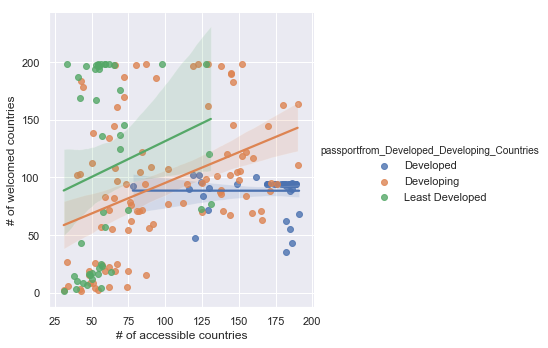

In [104]:
sns.set()

# Plot sepal with as a function of sepal_length across days
g = sns.lmplot(x="visafree", y="visafreeTO", hue="passportfrom_Developed_Developing_Countries",
               truncate=True, height=5, data=df_final)

# Use more informative axis labels than are provided by default
g.set_axis_labels("# of accessible countries", "# of welcomed countries")

## Correlation between sub-region and visa free

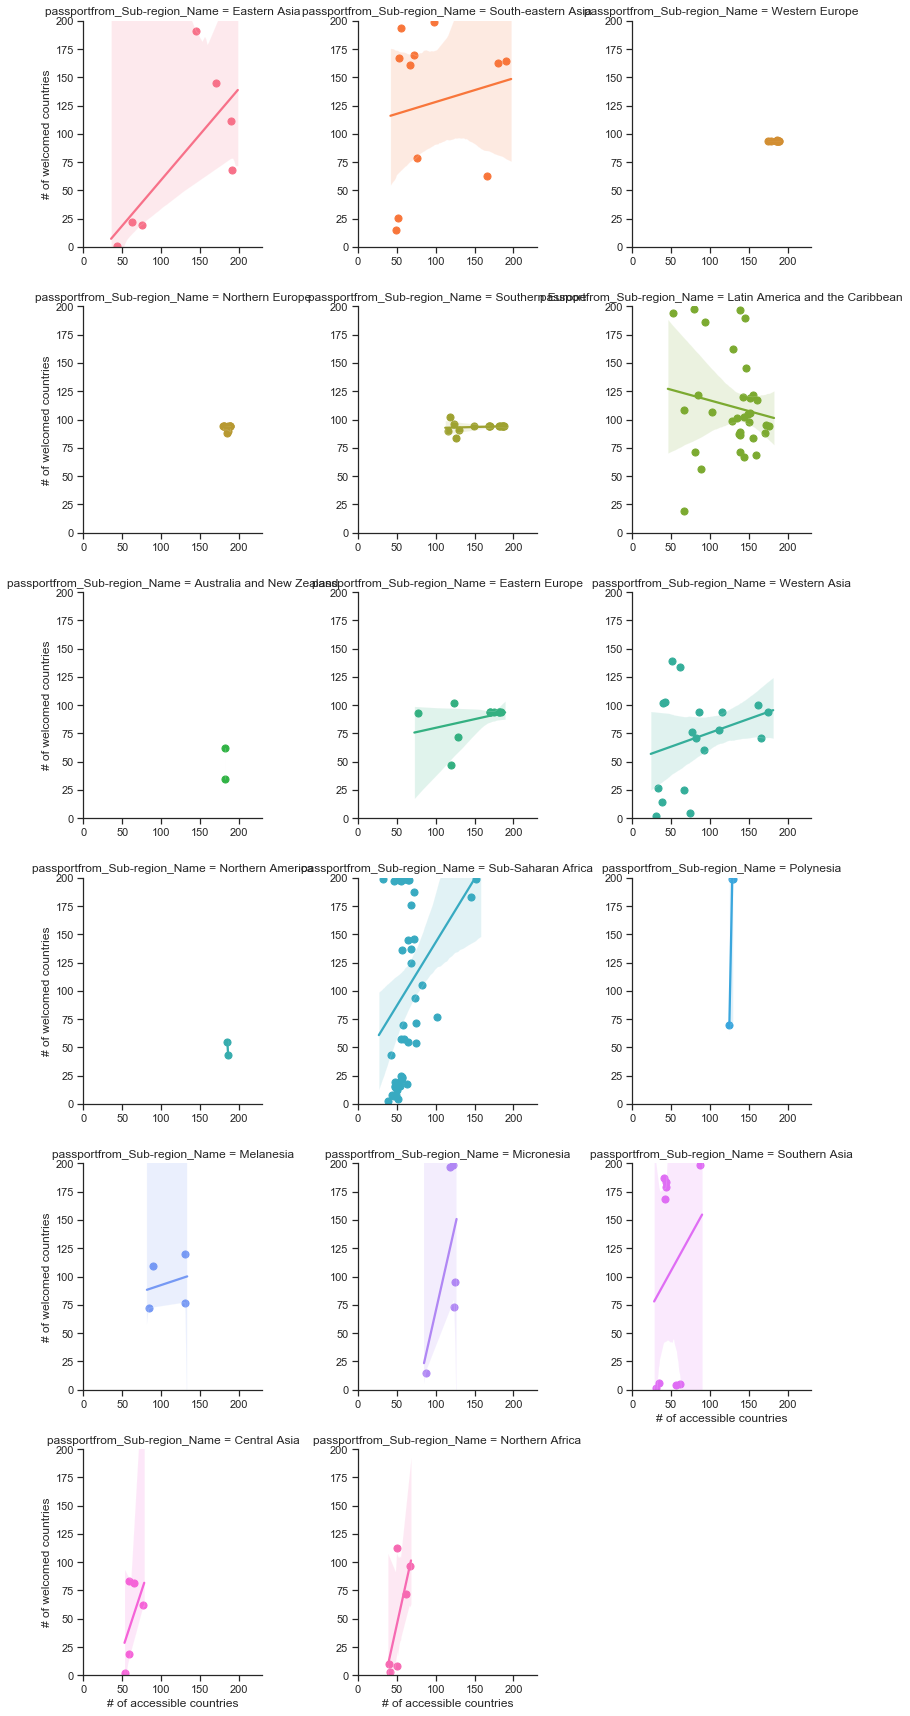

In [105]:
sns.set(style="ticks")

# Show the results of a linear regression within each dataset
g = sns.lmplot(x="visafree", y="visafreeTO", col="passportfrom_Sub-region_Name", hue="passportfrom_Sub-region_Name", data=df_final,
               sharex=False,sharey=False,
               col_wrap=3,
               #ci=None, 
               #palette="muted",
               height=4,
               scatter_kws={"s": 50, "alpha": 1}
              )

# control x and y limits
g.set(ylim=(0, 200))
g.set(xlim=(0, 230))

# Use more informative axis labels than are provided by default
g.set_axis_labels("# of accessible countries", "# of welcomed countries")

## Heatmap of the new passport ranking

In [106]:
data = [ dict(
        type = 'choropleth',
        locations = df_final['country_alpha_3code'],
        z = df_final['New_Overall_ranking'],
        text = "<br />" + df_final['passportfrom_Country_name'] + "'s passport gives you access to"
                + "<br />" + df_final['visafree'].astype(int).astype(str) + " destinations visa-free (over " + str(df_visa_free['countryto_alpha_2code'].nunique()) + " possible)"
                + "<br /><br />" + "It ranks " +  df_final['New_Overall_ranking'].astype(int).astype(str) + " th overall, " + df_final['ranking_bySubRegion'].astype(int).astype(str) + " th in " + df_final['passportfrom_Sub-region_Name'] 
                + "<br /><br />That's a visa-free coverage of:"
                + "<br />" + (df_final['UN_World_GDP_percent'].astype(float)*100).astype(int).astype(str) + " % of the world's GDP"  
                + "<br />" + (df_final['UN_population_Value_2015_percent'].astype(float)*100).astype(int).astype(str) + " % of the world's population"
                + "<br />" + (df_final['Surface_area_covered_percent'].astype(float)*100).astype(int).astype(str) +  " % of the earth's land surface"
                + "<br />" + (df_final['unesco_total_sites_percent'].astype(float)*100).astype(int).astype(str) + " % of the Unesco's heritage sites"
                + "<br /><br />In " + df_final['passportfrom_Country_name'] + ", " + df_final['visafreeTO'].astype(int).astype(str) + " citizenships are welcomed visa-free"
                + "<br />" + "That's a ratio of " + df_final['visaFreeRatio'].astype(str),
        autocolorscale = True,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            tickmode = 'array',
            tickvals = [180,100,20],
            ticktext = ['Weak','Medium','Strong'],
            autotick = False,
            #tickprefix = 'test',
            title = 'Passport rank. 1 = best'),
      ) ]

layout = dict(
    title = 'Passport rank heatmap',
    geo = dict(
        showframe = True,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='passports-world-map1' )

C:\Users\Jrmy\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## Heatmap visualization of the ratio countries accessibles vs countries welcomed visa-free

In [107]:
data = [ dict(
        type = 'choropleth',
        locations = df_final['country_alpha_3code'],
        z = df_final['visaFreeRatio'],
        text = "<br />" + df_final['passportfrom_Country_name'] + "'s passport gives you access to"
                + "<br />" + df_final['visafree'].astype(int).astype(str) + " destinations"
                + "<br /><br />" + df_final['visafreeTO'].astype(int).astype(str) + " citizenships are welcomed visa-free"
                + "<br /><br />" + "That's a ratio of " + round(df_final['visaFreeRatio'],1).astype(str),
        autocolorscale = False,
        reversescale = False,
        colorscale = [[0, 'rgb(51,160,44,0.5)'], #green
                      [0.05, 'rgb(178,223,138,0.5)'], #light green
                      [0.08, 'rgb(255,255,255,0.5)'], #white
                      [0.12, 'rgb(251,154,153,0.5)'], # salmon
                      [1, 'rgb(227,26,28,0.5)']], #red
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
    
        colorbar = dict(
            autotick = False,
            tickmode = 'array',
            #tickprefix = '',
            title = 'Ratio'),
      ) ]



layout = dict(
    title = 'ratio countries accessibles vs countries welcomed visa-free',
    geo = dict(
        showframe = True,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='passports-world-map2' )

C:\Users\Jrmy\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead

